<center><img src="car.jpg" width=500></center>


Insurance companies invest a lot of time and money into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries it is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

(`Source: https://www.accenture.com/_acnmedia/pdf-84/accenture-machine-leaning-insurance.pdf`) 

**Scenario:**, ***On the Road*** car insurance has requested your services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked you to identify the single feature that results in the best performing model, as measured by accuracy, so they can start with a simple model in production.

### Objective

Identify the single feature of the data that is the best predictor of whether a customer will put in a claim (the "outcome" column), excluding the "id" column.

They have supplied you with their customer data as a csv file called `car_insurance.csv`, along with a table detailing the column names and descriptions below.



## The dataset

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

In [1]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

In [2]:
df_car_ins = pd.read_csv("car_insurance.csv")
df_car_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

In [3]:
df_car_ins.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


## `age`

Age is encoded as a categorical variable with 4 levels 0-4. These levels are ordinal in that the higher the level, the higher the age range being represented in that bucket. Because of this oridinality, we can treat these as continuous variables for analysis purposes.

| Column | Description |
|--------|-------------|
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |



In [4]:
# start by getting just the data we need for this predictor
df_age = df_car_ins.loc[:, ['age', 'outcome']]
df_age.head()

,age,outcome
0,3,0.0
1,0,1.0
2,0,0.0
3,0,0.0
4,1,1.0


In [5]:
# contingency table
contingency_age = pd.crosstab(df_age['age'], df_age['outcome'], margins=True)
print(contingency_age, "\n")

contingency_age_norm = pd.crosstab(df_age['age'], df_age['outcome'], margins=True, normalize='index')
print(contingency_age_norm)

outcome   0.0   1.0    All
age                       
0         568  1448   2016
1        2031  1032   3063
2        2474   457   2931
3        1794   196   1990
All      6867  3133  10000 

outcome       0.0       1.0
age                        
0        0.281746  0.718254
1        0.663075  0.336925
2        0.844081  0.155919
3        0.901508  0.098492
All      0.686700  0.313300


+ As we'd expect, the older the drive, the less likely they are to file a claim.
+ Model will predict **Made a claim** for the first age bucket (16-25), but predict **No claim** for the other 3 age buckets.

In [6]:
threshold = 0.5  # make threshold explicit

mdl_age = logit("outcome ~ age", data=df_age).fit()

exploratory_data = pd.DataFrame({"age": np.arange(0, 4, 1)})
prediction_data = exploratory_data.assign(
    prob_filed = mdl_age.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['prob_filed'] > threshold).astype(float)

Optimization terminated successfully.
         Current function value: 0.511794
         Iterations 6


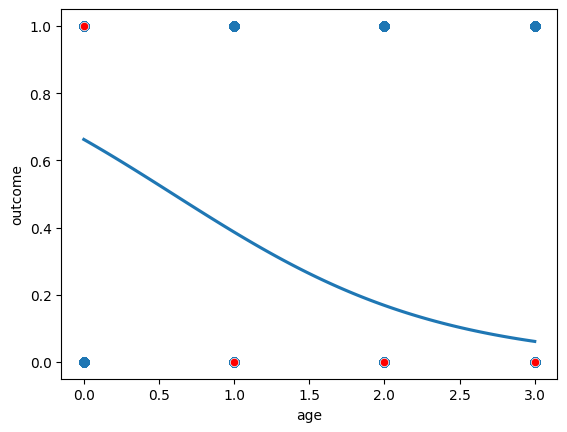

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_log_reg(x_act, x_pred, y_act, y_pred, df_act, df_pred):
    """ plots the results of a binary logistic regression model

    Args:
        x_act (str): name of the 
        x_pred (str):
        y_act (str):
        y_pred (str):
        df_act (Dataframe):
        df_pred (Dataframe):
    """
    sns.regplot(x=x_act, 
                y=y_act, 
                data=df_act, 
                ci=None, 
                logistic=True)

    sns.scatterplot(x=x_pred, 
                    y=y_pred, 
                    data=df_pred, 
                    color="red")

    plt.show()

# print(df_age.columns)
# print(prediction_data.columns)

plot_log_reg("age", "age", "outcome", "pred_outcome", df_age, prediction_data)

This plot looks like what we should expect:
+ *as age increase, probability of making a claim drops*
+ Model predicts a claim filing only in `age` = 0 bucket (red dot in the top part of the plot)
+ Model predicts `No claim` if `age` > 0

In [8]:
# compute confusion matrix
df_age['prob_file'] = mdl_age.predict(df_age['age'])
df_age['pred_file'] = (df_age['prob_file'] > threshold).astype(float)
conf_matrix = mdl_age.pred_table()
print(conf_matrix)
# print(type(conf_matrix))

[[6299.  568.]
 [1685. 1448.]]


In [9]:
# extract TN, TP, FN and FP from confusion matix
def get_accuracy(confusion_matrix):
    """ Calculated the accuracy from the confusion matrix

    Args:
        confusion_matrix (ndarray) - confusion matrix with rows as the actual values and columns as the predict values

    Returns:
        float: accuracy based on the confusion matrix
    """
    TN = confusion_matrix[0, 0]
    TP = confusion_matrix[1, 1]
    FN = confusion_matrix[1, 0]
    FP = confusion_matrix[0, 1]

    # print(f"TN = {TN}, TP = {TP}, FN = {FN}, "FP = {FP}")
    
    return ((TN + TP) / (TN + TP + FN + FP))

accuracy_age = get_accuracy(conf_matrix)
print(f"\nAccuracy using age only: {accuracy_age}")


Accuracy using age only: 0.7747


## `gender`

Gender is a binary categorical variable.

| Column | Description |
|--------|-------------|
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |

In [10]:
# start by getting just the data we need for this predictor
df_gender = df_car_ins.loc[:, ['gender', 'outcome']]
# contingency table
contingency_table = pd.crosstab(df_gender['gender'], df_gender['outcome'], margins=True)
print(contingency_table)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
# print(contingency_table.index)
# print(print(contingency_table.columns))
print(contingency_table)

outcome   0.0   1.0    All
gender                    
0        3689  1321   5010
1        3178  1812   4990
All      6867  3133  10000
outcome   0.0   1.0    All  prob_file
gender                               
0        3689  1321   5010   0.263673
1        3178  1812   4990   0.363126
All      6867  3133  10000   0.313300


Data suggest that women will file claims 26.4% of the time. Men will file 36.3% of the time. This is not a big difference, so we shouldn't expect this predictor to do very well.

In [11]:
mdl_gender = logit("outcome ~ gender", data=df_gender).fit()

exploratory_data = pd.DataFrame({"gender": np.array([0, 1])})
prediction_data = exploratory_data.assign(
    prob_filed = mdl_gender.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['prob_filed'] > threshold).astype(float)

Optimization terminated successfully.
         Current function value: 0.615951
         Iterations 5


[[6867.    0.]
 [3133.    0.]]

Accuracy using gender only: 0.6867



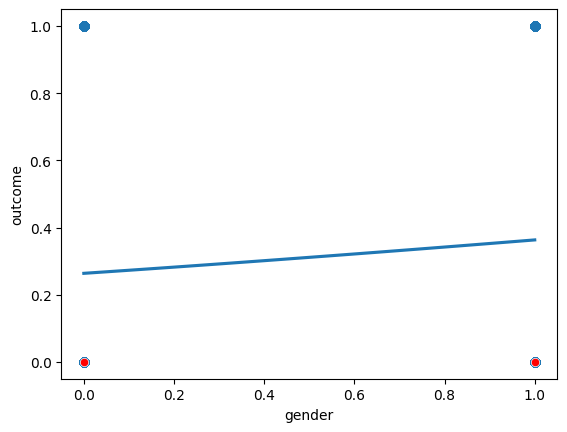

In [12]:
# compute confusion matrix
df_gender['prob_file'] = mdl_gender.predict(df_gender['gender'])
# df_age['prob_file'].unique()  # array([0.26367265, 0.36312625]) which are the values we computed above
df_gender['pred_file'] = (df_gender['prob_file'] > threshold).astype(float)
conf_matrix = mdl_gender.pred_table()
print(conf_matrix)  # neither gender shows > 50% probability of filing, so model will always predict "No claim"

accuracy_gender = get_accuracy(conf_matrix)
print(f"\nAccuracy using gender only: {accuracy_gender}\n")

plot_log_reg("gender", "gender", "outcome", "pred_outcome", df_gender, prediction_data)

+ The plot above looks a little funny because we're looking at a binary predictor, but is what we expect: *slightly high probability of filing if you are male*.
+ Since the probability of filing a claim is less than the threshold (50%) regardless of the `gender`, a model using this as the only predictor will always predict **No claim**.

## `driving_experience`

Like `age`, `driving_experience` is encoded as a categorical variable with 4 levels 0-4. These levels are also ordinal in that the higher the level, the more driving exprience being represented in that bucket. Because of this oridinality, we can treat these as continuous variables for analysis purposes.

| Column | Description |
|--------|-------------|
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |

This predictor may be **correlated** with the `age` predictor. Let's do a quick visual check.

In [13]:
df_age_drex = df_car_ins.loc[:, ['age', 'driving_experience', 'outcome']]
df_age_drex['driving_experience'].unique()

array(['0-9y', '10-19y', '20-29y', '30y+'], dtype=object)

In [14]:
df_age_drex = df_car_ins.loc[:, ['age', 'driving_experience', 'outcome']]
# need to convert driving_experience into an int representing the oridinality of the data
df_age_drex['encoded_drex'] = df_age_drex['driving_experience']
df_age_drex['encoded_drex'] = df_age_drex['encoded_drex'].str.replace('0-9y', '0')
df_age_drex['encoded_drex'] = df_age_drex['encoded_drex'].str.replace('10-19y', '1')
df_age_drex['encoded_drex'] = df_age_drex['encoded_drex'].str.replace('20-29y', '2')
df_age_drex['encoded_drex'] = df_age_drex['encoded_drex'].str.replace('30y+', '3')
df_age_drex['encoded_drex'] = df_age_drex['encoded_drex'].astype(float)

df_age_drex['encoded_drex'].unique()

array([0., 1., 2., 3.])

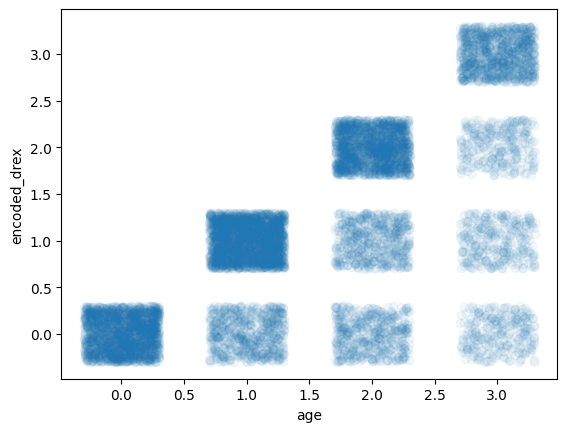

In [15]:
sns.regplot(data=df_age_drex, x='age', y='encoded_drex', fit_reg = False, x_jitter = 0.3, y_jitter = 0.3, scatter_kws = {'alpha' : 1/20})
plt.show()  # looks strong on the diagonal, but there are some older drivers with less experience

In [16]:
# contingency table
contingency_table = pd.crosstab(df_age_drex['driving_experience'], df_age_drex['outcome'], margins=True)
# print(contingency_table)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
# print(contingency_table.index)
# print(print(contingency_table.columns))
print(contingency_table)

outcome              0.0   1.0    All  prob_file
driving_experience                              
0-9y                1313  2217   3530   0.628045
10-19y              2512   787   3299   0.238557
20-29y              2010   109   2119   0.051439
30y+                1032    20   1052   0.019011
All                 6867  3133  10000   0.313300


Like the `age` predictor, we have one bucket (`0-9y`) that will be predicted as `Made a claim` and the others will not.

Optimization terminated successfully.
         Current function value: 0.467390
         Iterations 7


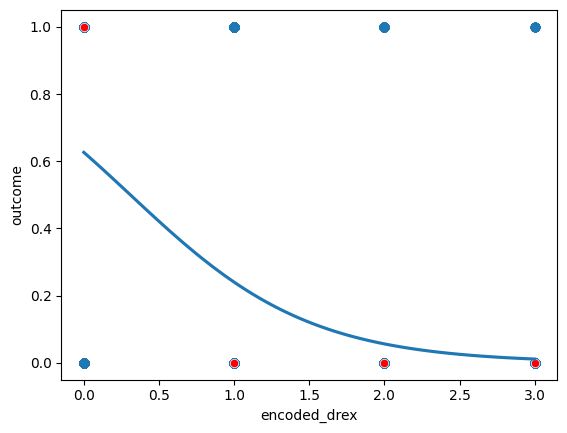

In [17]:
mdl_drex = logit("outcome ~ encoded_drex", data=df_age_drex).fit()

exploratory_data = pd.DataFrame({"encoded_drex": np.arange(0, 4, 1)})  # 4 buckets 0, 1, 2, 3
prediction_data = exploratory_data.assign(
    prob_filed = mdl_drex.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['prob_filed'] > threshold).astype(float)
plot_log_reg("encoded_drex", "encoded_drex", "outcome", "pred_outcome", df_age_drex, prediction_data)  # similar shape to age plot

In [18]:
# compute confusion matrix
df_age_drex['prob_file'] = mdl_drex.predict(df_age_drex['encoded_drex'])
df_age_drex['pred_file'] = (df_age_drex['prob_file'] > threshold).astype(float)
conf_matrix = mdl_drex.pred_table()
print(conf_matrix)

[[5554. 1313.]
 [ 916. 2217.]]


In [19]:
accuracy_drex = get_accuracy(conf_matrix)
print(f"\nAccuracy using driving experience only: {accuracy_drex}")  # a little better than age (0.7747 vs 0.7771)


Accuracy using driving experience only: 0.7771
